In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns

In [24]:
df = pd.read_csv('customer_segmentation.csv', encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [25]:
df.shape

(541909, 8)

In [26]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [28]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [29]:
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012


In [30]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceYearMonth
count,541909.000000,541909,541909.000000,406829.000000,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,201099.713989
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,201012.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,201103.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,201107.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,201110.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,201112.000000
std,218.081158,NaN,96.759853,1713.600303,25.788703


# RFM Clustering

Recenecy, Frequency and Monetary value. We will cluster based on these 3 factors.

In [31]:
id_data = pd.DataFrame(df['CustomerID'].unique())
id_data.columns = ['CustomerID']
id_data.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


## Recency

In [32]:
#get the max purchase date for each customer and create a dataframe with it
max_purchase_data = df.groupby('CustomerID').InvoiceDate.max().reset_index()
max_purchase_data.columns = ['CustomerID','MaxPurchaseDate']
max_purchase_data.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-12-07 15:52:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


In [36]:
# Compute the difference between the last transaction of the dataset with
# last transaction dates of the individual customer IDs to obtain the recency score
max_purchase_data['Recency'] = (max_purchase_data['MaxPurchaseDate'].max() - max_purchase_data['MaxPurchaseDate']).dt.days
max_purchase_data.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


In [37]:
#merge this dataframe to our new user dataframe
user_df = pd.merge(id_data, max_purchase_data[['CustomerID','Recency']], on='CustomerID')
user_df.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,12583.0,2
3,13748.0,95
4,15100.0,329


<Axes: xlabel='Recency', ylabel='Count'>

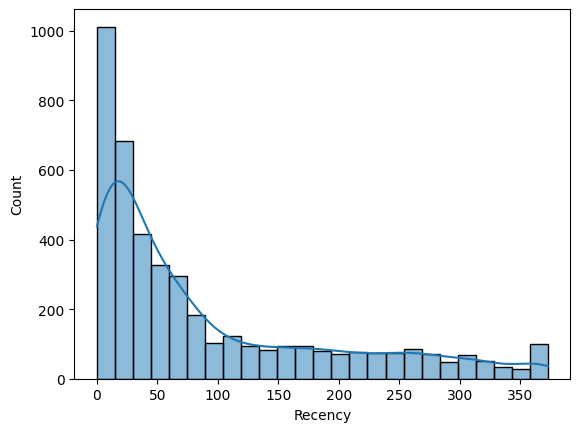

In [39]:
sns.histplot(user_df['Recency'], kde=True)

The optimal number of clusters is 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

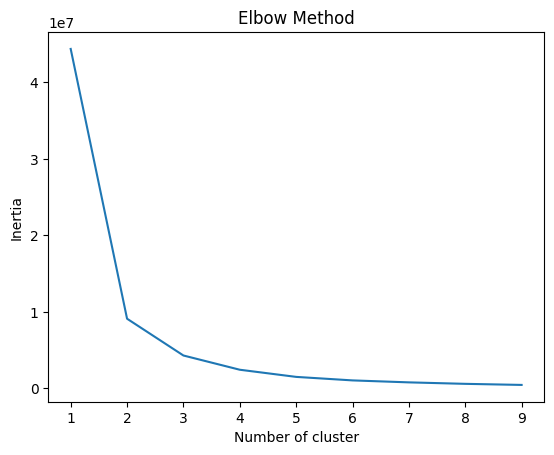

In [42]:
inertia = {} # error
tx_recency = user_df[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
    inertia[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [44]:
#build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
user_df['RecencyCluster'] = kmeans.fit_predict(user_df[['Recency']])
user_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,CustomerID,Recency,RecencyCluster
0,17850.0,301,1
1,13047.0,31,0
2,12583.0,2,0
3,13748.0,95,2
4,15100.0,329,1


In [61]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [62]:
user_df = order_cluster('RecencyCluster', 'Recency', user_df, False)

user_df.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,634.0,294.372240,45.419375,224.0,256.00,287.0,329.0,373.0
1,804.0,152.436567,38.057794,92.0,118.75,151.0,184.0,222.0
2,2934.0,30.288684,25.056571,0.0,9.00,23.0,49.0,91.0


## Frequency

In [46]:
#get order counts for each user and create a dataframe with it
frequency_data = df.groupby('CustomerID').InvoiceDate.count().reset_index()
frequency_data.columns = ['CustomerID','Frequency']

In [47]:
frequency_data.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [48]:
user_df = pd.merge(user_df, frequency_data, on='CustomerID')
user_df.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,1,312
1,13047.0,31,0,196
2,12583.0,2,0,251
3,13748.0,95,2,28
4,15100.0,329,1,6


<Axes: xlabel='Frequency', ylabel='Count'>

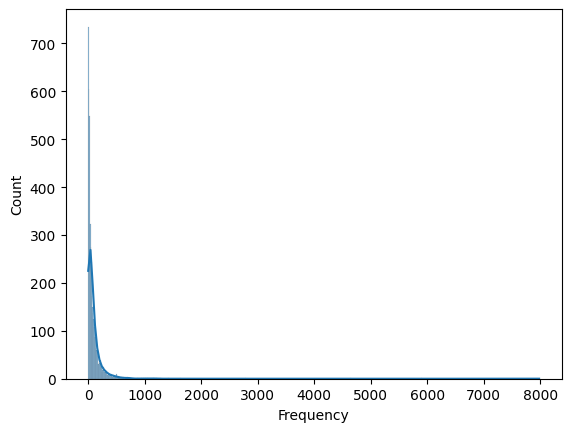

In [49]:
sns.histplot(user_df['Frequency'], kde=True)

<Axes: xlabel='Frequency', ylabel='Count'>

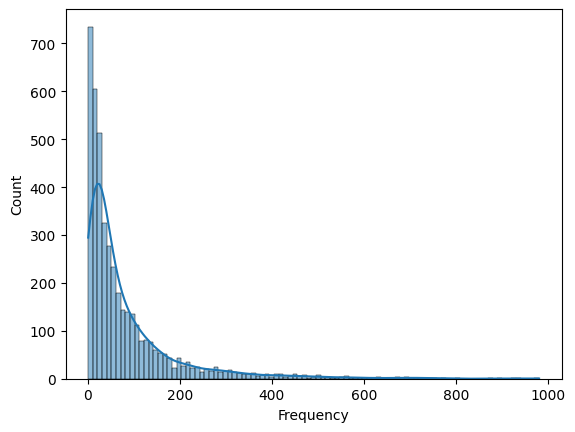

In [50]:
sns.histplot(user_df[user_df['Frequency']<1000]['Frequency'], kde=True)

There should be 4 clusters based on elbow method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-51-7a4501f71d68>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-51-7a4501f71d68>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

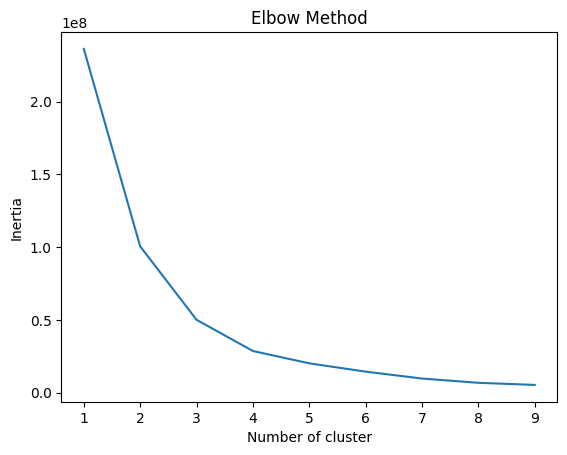

In [51]:
inertia = {} # error
tx_recency = user_df[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
    inertia[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [64]:
# Applying k-Means
kmeans=KMeans(n_clusters=4)
user_df['FrequencyCluster']=kmeans.fit_predict(user_df[['Frequency']])

user_df = order_cluster('FrequencyCluster', 'Frequency', user_df, True)

#order the frequency cluster
user_df.groupby('FrequencyCluster')['Frequency'].describe()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3862.0,49.753755,44.812998,1.0,15.0,34.0,73.0,189.0
1,482.0,329.107884,132.670589,190.0,228.0,286.0,393.5,803.0
2,24.0,1349.750000,508.637759,872.0,1003.5,1156.0,1541.0,2782.0
3,4.0,5914.000000,1473.845537,4642.0,5006.5,5515.5,6423.0,7983.0


## Revenue

In [53]:
#calculate revenue for each customer
df['Revenue'] = df['UnitPrice'] * df['Quantity']
revenue_df = df.groupby('CustomerID').Revenue.sum().reset_index()

In [54]:
revenue_df.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [55]:
user_df = pd.merge(user_df, revenue_df, on='CustomerID')
user_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,1,312,0,5288.63
1,13047.0,31,0,196,0,3079.10
2,12583.0,2,0,251,0,7187.34
3,13748.0,95,2,28,2,948.25
4,15100.0,329,1,6,2,635.10


<Axes: xlabel='Revenue', ylabel='Count'>

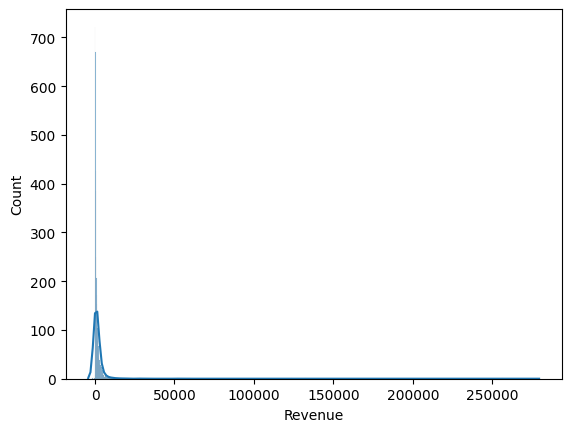

In [56]:
sns.histplot(user_df['Revenue'], kde=True)

<Axes: xlabel='Revenue', ylabel='Count'>

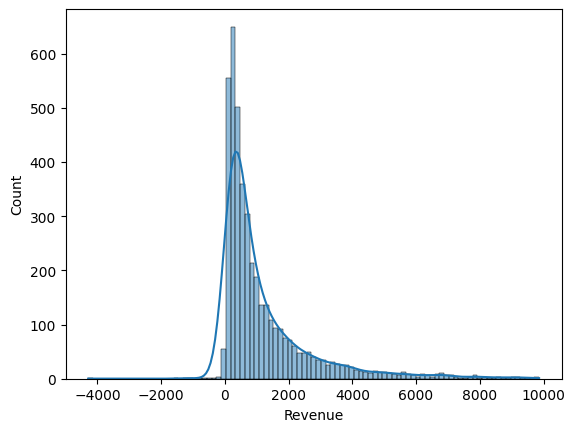

In [57]:
sns.histplot(user_df[user_df['Revenue']<10000]['Revenue'], kde=True)

There are 3 clusters based on the elbow plot

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-58-b808bc09dd28>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-58-b808bc09dd28>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

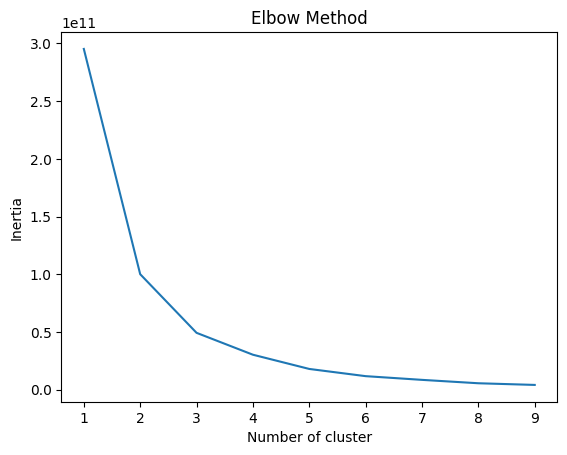

In [58]:
inertia = {} # error
tx_recency = user_df[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
    inertia[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [65]:
#apply clustering
kmeans = KMeans(n_clusters=3)
user_df['RevenueCluster'] = kmeans.fit_predict(user_df[['Revenue']])

user_df = order_cluster('RevenueCluster', 'Revenue', user_df, True)

#show details of the dataframe
user_df.groupby('RevenueCluster')['Revenue'].describe()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,4346.0,1434.198064,2434.685315,-4287.63,291.910,642.805,1572.155,29072.10
1,23.0,58418.754348,29262.836683,30300.82,35078.555,51823.720,61036.220,132572.62
2,3.0,241136.560000,47874.073443,187482.17,221960.330,256438.490,267963.755,279489.02


In [66]:
user_df['Score'] = user_df['RecencyCluster'] + user_df['FrequencyCluster'] + user_df['RevenueCluster']
user_df.head()

,CustomerID,Recency,Frequency,Revenue,RecencyCluster,FrequencyCluster,RevenueCluster,Score
0,17850.0,301,312,5288.63,0,1,0,1
1,15808.0,305,210,3724.77,0,1,0,1
2,13047.0,31,196,3079.10,2,1,0,3
3,12583.0,2,251,7187.34,2,1,0,3
4,14688.0,7,359,5107.38,2,1,0,3


In [68]:
user_df['Score'].describe()

count    4372.000000
mean        1.656679
std         0.896583
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         6.000000
Name: Score, dtype: float64